## Importing models , libraries

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error , mean_absolute_error , r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression , Ridge , Lasso
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV , train_test_split
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

## Data loading , preprocessing 

In [50]:
df= pd.read_csv("data/stud.csv")
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [51]:
X = df.drop(['math_score'],axis=1)
y=df['math_score']   # Target feature
num_features = X.select_dtypes(include=["int64","float64","int32","float32"]).columns.to_list()
cat_features = X.select_dtypes(include=['object','category']).columns.to_list()


In [52]:
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.compose import ColumnTransformer

cat_encoder = OneHotEncoder()
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    [
        ("onehotencoder",cat_encoder,cat_features),
        ("Scaler",scaler,num_features)
    ]
)

In [53]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.15,shuffle=True,random_state = 42)
X_train,X_val,y_train , y_val = train_test_split(X_train , y_train,test_size=0.2,random_state=42)

In [54]:
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [55]:
def evaluation_metrics(true,predicted):
    mae = mean_absolute_error(true,predicted)
    mse = mean_squared_error(true,predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true,predicted)
    return mae , mse , rmse ,  r2_square

## Model training and selection 

In [56]:
# Model train
models = {
    'linear regression' : LinearRegression(),
    'lasso regression' : Lasso(),
    'Ridge regression' : Ridge(),
    'SVM regressor' : SVR(),
    'decision tree' : DecisionTreeRegressor(),
    'random forest' : RandomForestRegressor(),
    'catboost' : CatBoostRegressor(verbose=False),
    'XGboost' : XGBRegressor(),
    'Kneighbors' : KNeighborsRegressor(),
}

model_list =[]
mae_error_list=[]
mse_error_list=[]
r2_error_list=[]

for i in range(len(models)):
    
    model = list(models.values())[i]
    model.fit(X_train , y_train)
    model_list.append(list(models.keys())[i])
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    mae_t , mse_t , rmse_t, r2_square_t = evaluation_metrics(true=y_train , predicted=y_train_pred)
    mae_v , mse_v , rmse_v , r2_square_v = evaluation_metrics(true = y_val , predicted= y_val_pred)

    print(f"model : [{list(models.keys())[i]}] trained")
    print("===============================================")
    print("training phase")
    print(f"mae = {mae_t} ,  mse = {mse_t}  , rmse = {rmse_t} , r2_square = {r2_square_t}")
    print("validation phase")
    print(f"mae = {mae_v} ,  mse = {mse_v}  , rmse = {rmse_v} , r2_square = {r2_square_v}")
    print("===============================================")

    mae_error_list.append(mae_v)
    mse_error_list.append(mse_v)
    r2_error_list.append(r2_square_v)


model : [linear regression] trained
training phase
mae = 4.274784891256203 ,  mse = 28.675120978241456  , rmse = 5.354915590206951 , r2_square = 0.8734334365392029
validation phase
mae = 4.33952601859108 ,  mse = 28.828522546152453  , rmse = 5.369219919704579 , r2_square = 0.8612439314587456
model : [lasso regression] trained
training phase
mae = 5.255453888365124 ,  mse = 44.22073817013429  , rmse = 6.649867530269629 , r2_square = 0.8048180208850568
validation phase
mae = 5.564277894118795 ,  mse = 48.00676313718052  , rmse = 6.928691300467969 , r2_square = 0.7689361393514973
model : [Ridge regression] trained
training phase
mae = 4.2727670740778745 ,  mse = 28.679115770842746  , rmse = 5.355288579604534 , r2_square = 0.8734158042798075
validation phase
mae = 4.336974369708427 ,  mse = 28.83466036447544  , rmse = 5.369791463779151 , r2_square = 0.8612143892045925
model : [SVM regressor] trained
training phase
mae = 5.0511946232839895 ,  mse = 47.660883222376995  , rmse = 6.90368620538

In [66]:
# Choosing the best model according to R2 square metrics 

pd.DataFrame(list(zip(model_list,r2_error_list)),columns=['model','r2 accuracy']).sort_values(by=["r2 accuracy"],ascending=False)

,model,r2 accuracy
0,linear regression,0.861244
2,Ridge regression,0.861214
6,catboost,0.839176
5,random forest,0.804080
3,SVM regressor,0.786990
1,lasso regression,0.768936
7,XGboost,0.764134
8,Kneighbors,0.759655
4,decision tree,0.604500


In [69]:
X_train_full  = np.concatenate([X_train,X_val],axis=0)
y_train_full = pd.concat([y_train,y_val],axis=0).to_numpy()


In [73]:
final_model = LinearRegression()
final_model.fit(X_train_full,y_train_full)
y_pred_train = final_model.predict(X_train_full)
y_pred_test = final_model.predict(X_test)

mae_t , mse_t , rmse_t , r2_square_t = evaluation_metrics(y_train_full , y_pred_train)
mae , mse , rmse , r2_square = evaluation_metrics(y_test , y_pred_test)


print("Training errors :")
print(f"mae = {mae_t} ,  mse = {mse_t}  , rmse = {rmse_t} , r2_square = {r2_square_t}")
print("===============================================")
print("model evaluation :- ")
print(f"mae = {mae} ,  mse = {mse}  , rmse = {rmse} , r2_square = {r2_square}")
print("===============================================")


Training errors :
mae = 4.278367178752692 ,  mse = 28.573075059558803  , rmse = 5.345378850891563 , r2_square = 0.8717602764283403
model evaluation :- 
mae = 4.077417416986165 ,  mse = 27.591893072693054  , rmse = 5.252798594339312 , r2_square = 0.8946549786778092


#### The mean absolute error shows that the error in the math score prediction is about +- 4 degrees .

the test set error is slightly better than the training set error due to the small size of the test set where lucky points that lies near the regression line have high impact

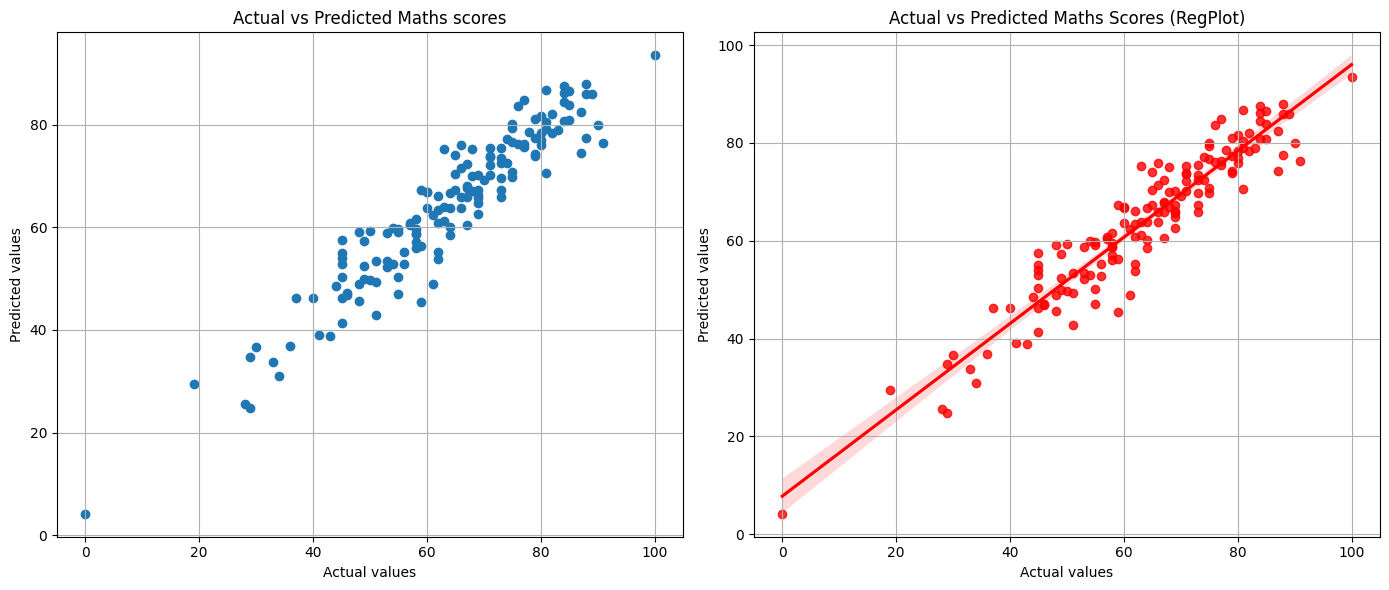

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  

axs[0].scatter(y_test, y_pred_test)
axs[0].grid(True)
axs[0].set_xlabel("Actual values")
axs[0].set_ylabel("Predicted values")
axs[0].set_title("Actual vs Predicted Maths scores")

sns.regplot(x=y_test, y=y_pred_test, color='red', ax=axs[1])
axs[1].grid(True)
axs[1].set_xlabel("Actual values")
axs[1].set_ylabel("Predicted values")
axs[1].set_title("Actual vs Predicted Maths Scores (RegPlot)")

plt.tight_layout()
plt.show()